# DEM management

DEM are used in two ways in **EOReader**:
- for computing DEM bands (`DEM`, `SLOPE`, `HILLSHADE`)
- for orthorectification (SAR, with SNAP or VHR data)

There are several things you need to know to handle DEMs properly.

In [1]:
# Imports
import os
import tempenv

import matplotlib.pyplot as plt

from eoreader.reader import Reader
from eoreader.bands import DEM, SLOPE, HILLSHADE, VV, RED
from eoreader.env_vars import DEM_PATH, DEM_VCRS, SNAP_DEM_NAME, SAR_DEF_PIXEL_SIZE
from eoreader.keywords import DEM_KW, SLOPE_KW, HILLSHADE_KW
from eoreader.products import SnapDems

In [2]:
# Create logger
import logging
from sertit import logs

logger = logging.getLogger("eoreader")
logs.init_logger(logger)
# logs.init_logger(logging.getLogger("sertit"))

In [ ]:
# Open the product
path = os.path.join("/home", "prods", "S2", "PB 02.07+", "S2B_MSIL2A_20200114T065229_N0213_R020_T40REQ_20200114T094749.SAFE")
prod = Reader().open(path)

In [3]:
# DEM paths
dem_folder = os.path.join("/home", "ds2_db2", "BASES_DE_DONNEES", "GLOBAL")
dtm = os.path.join(dem_folder, "MERIT_Hydrologically_Adjusted_Elevations", "MERIT_DEM.vrt")
dem = os.path.join(dem_folder, "COPDEM_30m", "COPDEM_30m.vrt")

___
## DEM bands
DEM bands are computed using the DEM stored in the `EOREADER_DEM_PATH` environment variable.  
Without anything specified, DEM bands cannot be computed and an error will be thrown.


<div class="alert alert-warning">
  
<strong>Note:</strong> SAR products cannot load a <code>HILLSHADE</code> band !
    
</div>


In [ ]:
# Error when computing the DEM band: It hasn't been specified to EOReader
try:
    prod.load(DEM)[DEM]
except ValueError as msg:
   logger.error(msg)     

In [ ]:
# This works now
with tempenv.TemporaryEnvironment({DEM_PATH: dem}):
    prod.load(DEM)[DEM]

However, in some cases, you may want to specify a specific DEM to load a band from it.

The most common use of this is:
- I want to compute the hillshade from a DEM
- I want to compute the slope of a DTM as I don't want the slopes of buildings or trees !
- I want those two bands coregistered by default

When specifying a DEM in the `load` or `stack` function, you don't need to set the `EOREADER_DEM_PATH` environment variable

In [ ]:
# DEM has been loaded before and won't be recomputed
dem_bands = prod.load(
    [DEM, SLOPE, HILLSHADE],
    pixel_size=60,
    **{
        DEM_KW: dem,
        SLOPE_KW: dtm, # We want a DTM here
        HILLSHADE_KW: dem,        
    }
)

In [ ]:
# Plot DEM bands
ncols = len(dem_bands)
plt.figure(figsize=(6, 6 * ncols))
i = 0
for key in dem_bands.keys():
    axes = plt.subplot(3, 1, i+1)
    dem_bands[key][0, ::5, ::5].plot.imshow(
        robust=True, 
        cmap="mako", 
        interpolation="gaussian", 
        interpolation_stage="data"
    )
    i += 1

____
## Orthorectification
### SAR orthorectification (with SNAP)

SNAP uses its own DEM mechanics: it downloads DEM tiles on its own and everything is managed without any intervention of the user.

By default, **EOReader** forces SNAP to use the `COPDEM-30` (`GLO-30`) as its a global DTM.

However, this can be modified by setting the environment variable overriding the default DEM name used in SNAP.
The user can choose `GETASSE30`, `SRTM 3Sec`, `External DEM`...

If `EOREADER_SNAP_DEM_NAME` is set to `External DEM`, SNAP will use the DEM stored in `EOREADER_DEM_PATH` as an external DEM.

<div class="alert alert-warning">
  
<strong>Warning:</strong> It seems that SNAP can only DEM with TIF format and not VRT. <br>
Using such DEM format would result with the following error message: <code>Error: No product reader found for /path/to/dem.vrt</code> 
    
</div>

The default resolution of the orthorectification computed by SNAP can be controlled through the `EOREADER_SAR_DEFAULT_PIXEL_SIZE` environment variable.

In [ ]:
# Open a SAR product
path = os.path.join("/home", "prods", "ICEYE", "SC_124020")
prod = Reader().open(path)
prod

In [ ]:
# Orthorectify the data at a coarser resolution to speed up process: Use 30 meters
os.environ[SAR_DEF_PIXEL_SIZE] = "30"

In [ ]:
# Orthorectifying with COPDEM-30
ortho = prod.load(VV)[VV]

In [ ]:
ortho[0, ::10, ::10].plot(cmap="mako", robust=True)

#### Orthorectifying with other DEM than default (GETASSE-30)

You have to update properly the environment variable with the correct DEM name.

With EOReader's variable, you can use:

```python
with tempenv.TemporaryEnvironment(
    {
        SNAP_DEM_NAME: SnapDems.GETASSE30.value
    }
):
    prod.load(...)
```

Or directly with strings:


```python
with tempenv.TemporaryEnvironment(
    {
        "EOREADER_SNAP_DEM_NAME": "GETASSE30"
    }
):
    prod.load(...)
```

#### Orthorectifying with custom DEM (EUDEM)

You have to update properly the environment variables with the external DEM and its path:

```python
with tempenv.TemporaryEnvironment(
    {
        SNAP_DEM_NAME: SnapDems.EXT_DEM.value,
        DEM_PATH: f"{dem_folder}/EUDEM_v2/eudem_wgs84.tif"
    }
):
    prod.load(...)
```

or 


```python
with tempenv.TemporaryEnvironment(
    {
        SNAP_DEM_NAME: "External DEM",
        DEM_PATH: f"{dem_folder}/EUDEM_v2/eudem_wgs84.tif"
    }
):
    prod.load(...)
```

### VHR orthorectification

Some products are not orthorectified by default (according what product type you bought).  
It may be wanted, in order to control yourself the orthorectification.  
**EOReader** can orthorectify VHR products: `DIMAP` (`Pleiades` and `SPOT`) and `Maxar` (`GeoEye` and `WorldView`) products.

<div class="alert alert-warning">
  
<strong>Warning:</strong> The orthorectification may take a while!
    
</div>

<div class="alert alert-warning">

<strong>Warning:</strong> Orthorectification with RPCs should be done with an ellipsoid-based DEM! <br>
EOReader is able to convert your put DEM if you provide the corresponding vertical CRS (passing a 'vcrs' keyword or put it in 'EOREADER_DEM_VCRS' environment variable). <br>
More insights here: https://xdem.readthedocs.io/en/stable/vertical_ref.html

</div>

In [4]:
# Open a VHR product in sensor geometry
path = os.path.join("/home", "prods", "SPOT", "IMG_SPOT7_MS_001_A")
prod = Reader().open(path)

In [ ]:
# Error when orthorectifying the RED band: the DEM hasn't been specified
try:
    prod.load(RED)[RED]
except ValueError as msg:
   logger.error(msg)

In [5]:
# With environment variable
# COPDEM-30 is based on EGM08
# (however, EOReader is able to detect COPDEM vertical CRS thanks to the filename: 
# it's looking for 'COPDEM' or 'Copernicus' in it)
with tempenv.TemporaryEnvironment({DEM_PATH: dem, DEM_VCRS: "EGM08"}):
    red = prod.load(RED, chunks=None)[RED]

2025-12-22 15:32:33,025 - [DEBUG] - Loading bands ['RED']
2025-12-22 15:32:33,026 - [INFO] - Manually orthorectified stack not given by the user. Reprojecting whole stack, this may take a while. (Might be inaccurate on steep terrain, depending on the DEM pixel size).
Reprojection with RPCs doesn't work with Dask. Computing the raster.
2025-12-22 15:32:50,838 - [DEBUG] - Read RED
2025-12-22 15:32:53,473 - [DEBUG] - Manage nodata for band RED
2025-12-22 15:32:53,473 - [DEBUG] - Load nodata
2025-12-22 15:32:53,497 - [INFO] - Orthorectifying ROI
2025-12-22 15:32:53,497 - [DEBUG] - 	Rasterizing ROI
2025-12-22 15:33:15,173 - [DEBUG] - 	Reprojecting ROI
Reprojection with RPCs doesn't work with Dask. Computing the raster.
2025-12-22 15:33:40,383 - [DEBUG] - 	Revectorizing ROI
2025-12-22 15:33:44,366 - [DEBUG] - Rasterizing ROI mask
2025-12-22 15:33:45,404 - [DEBUG] - Set nodata mask
2025-12-22 15:33:45,534 - [DEBUG] - Converting RED to reflectance


```python
# With keyword
red = prod.load(RED, **{DEM_KW: dem})[RED]
```

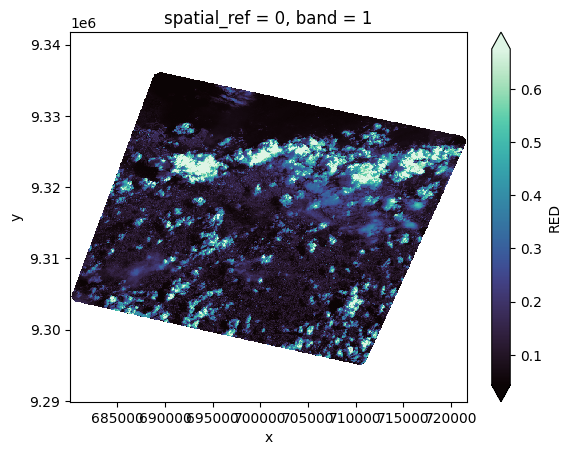

In [6]:
red[0, ::10, ::10].plot(cmap="mako", robust=True)